COH notes:
+ So 'Data-011' is Sensor B from swipe 1, I don't think I have video of that on
+ 'Data-014' is Sensor E from swipe 3 (this one is at the camera end of the bridge)
+ 'Data-014(1)' is Sensor D from swipe 3 and
+ 'Data-017' is Sensor B from swipe 6

In [1]:
import pandas as pd

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import ajf_plts
import string
import datetime

# Setup plotting style

In [2]:
plt.style.reload_library()

plt.style.use(['./ajf_plts/base.mplstyle',
               './ajf_plts/legend_frame.mplstyle'])

# Read in acceleration data

In [4]:
sens_D = pd.read_csv(
    "./data/mel_toome/Swipe3_SensorD.csv",
    names=["t", "x", "y", "z"],
    skiprows=9,
    skipfooter=1,
    engine="python",
    dtype=np.float64,
)
sens_D[["x", "y", "z"]] /= -13107.0

fs = 1.0 / np.mean(np.diff(sens_D.t.values))

v_length = 8.0  # metres
ax_length = 0.9
velocity = 17.8  # metre per second

v_win = v_length / velocity
ax_win = ax_length / velocity


WIN_LEN = int(v_win * fs)

sens_D["gv"] = np.linalg.det(
    sens_D[["x", "y", "z"]].rolling(WIN_LEN).cov().values.reshape(-1, 3, 3)
)

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [5]:
print("Window length:", v_win, "seconds")

Window length: 0.449438202247191 seconds


In [6]:
# sens_E["t"] -= 0.106  # this roughly time syncs the two sensors

In [7]:
# sens = pd.merge_asof(sens_D, sens_E, on="t").set_index("t")
sens = sens_D.set_index("t")

In [8]:
full_x = (575, 675)  # [475, 675]
event1_x = [650, 700]
event2_x = [340, 400]

index_series = sens.index.to_series()
full_mask = index_series.between(*full_x)
event1_mask = index_series.between(*event1_x)
event2_mask = index_series.between(*event2_x)

## Swipe 3 video - acc sync
+ Last strike of 4 initial hammer hits
  + Video timestamp 20:57:44
  + Sensor D timestamp 11.5 seconds
  + To convert Sensor D timestamp to video t_vid = 20:57:44 + t_sens - 11.5

In [9]:
video_hammer = datetime.timedelta(seconds=26)

sens_hammer_start_first = datetime.timedelta(seconds=4.2)
sens_hammer_end_first = datetime.timedelta(seconds=1635.0)
sens_first_first = sens_hammer_end_first - sens_hammer_start_first
print("Sensor First hammer - First hammer: ", sens_first_first)

vid_hammer_start_first = datetime.timedelta(hours=20, minutes=57, seconds=36)
vid_hammer_end_first = datetime.timedelta(hours=21, minutes=24, seconds=47)

vid_first_first = vid_hammer_end_first - vid_hammer_start_first

print("Video First hammer - First hammer: ", vid_first_first)


def conv_sens_time(t_sens):
    return (
        vid_hammer_start_first
        + datetime.timedelta(seconds=t_sens)
        - sens_hammer_start_first
    )


t_sens = 650
t_vid = (
    vid_hammer_start_first
    + datetime.timedelta(seconds=t_sens)
    - sens_hammer_start_first
)

print("Time sensor: ", t_sens, "seconds -> time video: ", conv_sens_time(t_sens))

Sensor First hammer - First hammer:  0:27:10.800000
Video First hammer - First hammer:  0:27:11
Time sensor:  650 seconds -> time video:  21:08:21.800000


In [10]:
data = sens[full_mask]
data.index -= full_x[0]

# Acceleration

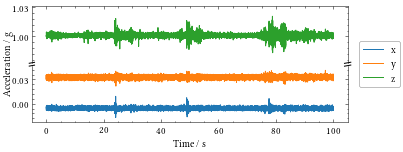

In [11]:
%matplotlib inline

N_ROWS = 1
N_COLS = 1

cap_axes = []

figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig = plt.figure(figsize=figsize)
outer = fig.add_gridspec(N_ROWS, N_COLS)

row = 0

# Acceleration plot with broken axis
gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], hspace=0.05)

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax.sharex(ax2)

# plot the same data on both axes
l1 = ax.plot(data[["x", "y", "z"]], ls="-")
l2 = ax2.plot(data[["x", "y", "z"]], ls="-")

# zoom-in / limit the view to different portions of the data
z_min = data.z.min()
z_max = data.z.max()
z_range = z_max - z_min
z_mid = (z_max + z_min) / 2.0


xy_min = data[["x", "y"]].min().min()
xy_max = data[["x", "y"]].max().max()
xy_range = xy_max - xy_min
xy_mid = (xy_max + xy_min) / 2.0

if z_range > xy_range:
    xy_lims = [xy_mid - z_range * 0.5, xy_mid + z_range * 0.5]
    z_lims = [z_min - z_range * 0.1, z_max + z_range * 0.1]
else:
    z_lims = [z_mid - xy_range * 0.5, z_mid + xy_range * 0.5]
    xy_lims = [xy_min - xy_range * 0.1, xy_max + xy_range * 0.1]


ax.set_ylim(z_lims)  # z channel
ax2.set_ylim(xy_lims)  # most of the data

# hide the spines between ax and ax2
ax.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
ax2.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = 0.01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color="k", clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

ax_fake = fig.add_subplot(gs[0:2, :], frameon=False)
ax_fake.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
ax_fake.set_xlabel("Time / s")
ax_fake.set_ylabel("Acceleration / g")

ax_fake.legend(l1, ["x", "y", "z"], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
ajf_plts.save_fig(fig, 'fig16.pdf')

# Generalised variance

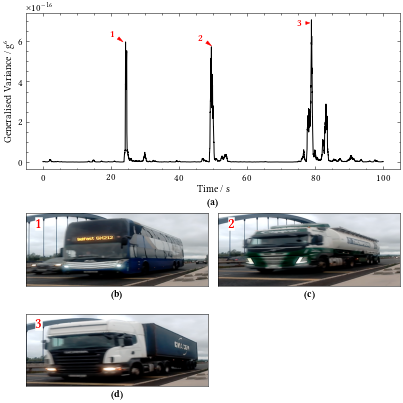

In [15]:
%matplotlib inline

cap_axes = []

figsize = (ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches)
fig = plt.figure(figsize=figsize)

# Overall GV plot
ax = fig.add_subplot(2, 1, 1)

data.gv.plot(ax=ax, c='k')
ax.set_ylabel(r"Generalised Variance / $\text{g}^6$")
ax.set_xlabel("Time / s")

annot_kwargs = dict(
    c="r",
    xycoords="data",
    textcoords="offset points",
    arrowprops=dict(color="red", arrowstyle="wedge"),
    horizontalalignment="right",
    verticalalignment="bottom",
)

ax.annotate(
    r"$\mathbf{1}$", xy=(599 - full_x[0], 5.9e-16), xytext=(-10, 5), **annot_kwargs
)
ax.annotate(
    r"$\mathbf{2}$", xy=(625 - full_x[0], 5.7e-16), xytext=(-10, 5), **annot_kwargs
)
ax.annotate(
    r"$\mathbf{3}$", xy=(654 - full_x[0], 6.9e-16), xytext=(-10, -5), **annot_kwargs
)

cap_axes.append(ax)


v_axes = [fig.add_subplot(4, 2, 5 + i) for i in range(3)]

[a.set_xticks([], []) for a in v_axes]
[a.set_yticks([], []) for a in v_axes]

# v_axes[0].imshow(mpl.image.imread("./504.png"), aspect="auto")
v_axes[0].imshow(mpl.image.imread("./data/mel_toome/600.png"), aspect="auto")
v_axes[1].imshow(mpl.image.imread("./data/mel_toome/625.png"), aspect="auto")
v_axes[2].imshow(mpl.image.imread("./data/mel_toome/654.png"), aspect="auto")

cap_axes.extend(v_axes)

ajf_plts.caption_axes(
    cap_axes,
)

ajf_plts.caption_subplots(
    v_axes,
    v_pos=0.95,
    h_pos=0.05,
    va="top",
    ha="left",
    labels=string.digits,
    label_format=r"$\mathbf{{{}}}$",
    start_val=1,
    kwargs=dict(
        c="r",
        size=14,
        bbox={"color": "white", "pad": 0},
    ),
)


fig.tight_layout (h_pad=-1.0)
ajf_plts.save_fig(fig, 'fig17.pdf')